In this part of the tutorial, we will be using a pre-trained model to perform some inference and detect anomalies in the pixel occupancy plots. This pre-trained model is based on residual networks (see [K. He et al, arXiv:1512.03385](https://arxiv.org/abs/1512.03385) for more info) and is constructed in the form of autoencoders in the same way as in the previous part. Unlike the 1D autoencoder we saw earlier, this model is a 2D autoencoder that accepts 2D histograms.

# What we need
- Four model files in hdf5 format. Vicha already has it somewhere.
- ZeroBias rate for **2022F** lumisections, obtained from OMS. We need this to normalise the histograms.

# Workflow in a nutshell
- Preprocess the histograms
    - Make sure that the histogram has the dimension of 200 x 140. We may have to trim it.
    - Normalise the histograms with a corresponding ZeroBias rate for each lumisection from OMS.
- Run the model
    - Reconstruct all four histograms per each lumisection
        - Input: histogram of 200 x 140
        - Output: _reconstructed_ histogram of 200 x 140
- Interpret the reconstruction
    - For each histogram in a lumisection, 
        - calculate the difference using MSE, then
        - calculate the mean of MSE from all pixels. 
        - We should have four numbers representing MSE loss for four histograms in each lumisection.
    - Perform PCA on a tuple of four numbers from all lumisections we have.

# Prerequisite packages and setups

In [1]:
# Prerequisite packages
import pickle
import numpy as np
import keras
import tensorflow as tf
import uproot
import sklearn.preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import os

import mplhep as hep
plt.style.use([hep.style.CMS])
hep.rcParams.label.data = True
hep.rcParams.label.paper = True
hep.rcParams.label.llabel = "Preliminary"
hep.rcParams.label.lumi = None
hep.rcParams.label.year = 2017

2023-10-16 10:48:09.094114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In this tutorial, we will follow suit and use nanoDQMIO file format, which conveniently stores 2D histograms in addition to 1D histograms.

In [2]:
# Assuming that you have DQMIOReader class set up from the previous tutorial...
from DQMIOReader import DQMIOReader

Welcome to JupyROOT 6.28/06


In [3]:
# We will read ALL nanoDQMIO files available simultaneously.
filenames = [os.path.join("/eos/home-v/vwachira/public/DESY ML tutorial/Luka_DQMIO_files/", f) \
             for f in os.listdir("/eos/home-v/vwachira/public/DESY ML tutorial/Luka_DQMIO_files/") if f[0] != '.']
dqmio_reader = DQMIOReader(*filenames)
dqmio_runs = pd.DataFrame(sorted(dqmio_reader.listLumis()), columns=["run_number", "lumisection_number"])

DQMIOReader.__init__: opening 64 files...
all files opened, now making index
index made, now making list of monitoring elements


The model we will be using here expects the input data to be normalised by ZeroBias HLT dataset rate, so we should obtain it as well. One way to do this is to use OMS API provided by Luka Lambrecht here: https://github.com/LukaLambrecht/ML4DQMDC-PixelAE/tree/master/omsapi. However, the API requires client ID and secret (pretty much like passwords), which can be obtained by registering an application ID with OMS developer team. You can have a look at the README file for the linked repo for more details.

As you might realise by now, we do not have time to set everything up, especially contacting OMS developer team (who are humans) to set up application IDs for all participants. So instead of using the API, we have prepared the JSON file containing ZeroBias and L1Accept dataset HLT rates. We will be using only ZeroBias here, so we have to strip and clean the ZeroBias database we have.

In [4]:
oms_rate = pd.read_json("rate_era_Run2022F.json")
oms_runs_withrate = oms_rate[~oms_rate["rate_ZeroBias"].isna()][["run_number", "lumisection_number", "rate_ZeroBias"]]
oms_runs_withrate = oms_runs_withrate.sort_values(by=["run_number", "lumisection_number"])

In [5]:
oms_runs_withrate

run_number  lumisection_number  rate_ZeroBias
131         360335                   1       8.622757
132         360335                   2       9.266246
133         360335                   3       9.266246
134         360335                   4       9.695239
135         360335                   5      10.038434
...            ...                 ...            ...
111320      362167                 652      80.135872
111321      362167                 653      24.538393
111322      362167                 654       9.437844
111323      362167                 655       4.633123
111324      362167                 656       1.158281

[67015 rows x 3 columns]

We will also have to check which runs are available in our nanoDQMIO files, so...

In [6]:
datasetrate_df = pd.merge(oms_runs_withrate, dqmio_runs, how="inner", \
                          on=["run_number", "lumisection_number"]).sort_values(by=["run_number", "lumisection_number"])

In [7]:
datasetrate_df

run_number  lumisection_number  rate_ZeroBias
0          360390                   5     105.489352
1          360390                   6     106.390237
2          360390                   7     106.004143
3          360390                   8     104.159474
4          360390                   9     107.848813
...           ...                 ...            ...
44344      362167                 642      78.033807
44345      362167                 643      81.422851
44346      362167                 644      79.663980
44347      362167                 645      78.462800
44348      362167                 646      79.663980

[44349 rows x 3 columns]

The final ingredient are the models. We can train all-new models here by using data from **2022F** era, but as these models are designed for 2D histograms using convolutional 2D layers, training them will take a huge amount of processing power, something only specialised machines like IBM Minsky can provide.

For demonstration purposes, we will use pretrained models using **2022F** data.

In [8]:
!ls /eos/home-v/vwachira/public/DESY\ ML\ tutorial/models_2022F

resnet_minsky_1_0.50_best.hdf5	resnet_minsky_3_0.50_best.hdf5
resnet_minsky_2_0.50_best.hdf5	resnet_minsky_4_0.50_best.hdf5


In [9]:
#models = [tf.keras.models.load_model(f"zphi{i}_resnet_v5/resnet_minsky_zphi{i}_0.50_best.hdf5", compile=False) for i in range(1, 5)]
models = [tf.keras.models.load_model(f"/eos/home-v/vwachira/public/DESY ML tutorial/models_2022F/resnet_minsky_{i}_0.50_best.hdf5", compile=False) \
          for i in range(1, 5)]

# Preprocessing

In [10]:
def gethist(runnr, lumisection):
    zphi_temps = []
    rate_series = datasetrate_df[(datasetrate_df["run_number"] == runnr) & (datasetrate_df["lumisection_number"] == lumisection)]["rate_ZeroBias"].to_list()
    if len(rate_series) != 1: raise Exception("Rate for this lumisection is not available!")
    rate = rate_series[0]
    for zphicount in range(1, 5):
        histobj = dqmio_reader.getSingleMEForLumi((runnr, lumisection), f"PixelPhase1/Tracks/PXBarrel/clusterposition_zphi_ontrack_PXLayer_{zphicount}").data
        hist = np.zeros((histobj.GetNbinsY(), histobj.GetNbinsX()))
        for i in range(histobj.GetNbinsX()):
            for j in range(histobj.GetNbinsY()):
                hist[j, i] = histobj.GetBinContent(i+1, j+1)
        hist = hist[:, 80:220]/rate
        hist = np.reshape(hist, (-1, 200, 140, 1))
        zphi_temps.append(hist)
    return zphi_temps, rate

In [11]:
# The models are built using Keras, so you can see the structure of the network using summary method.
models[0].summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 140, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 140, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu_1 (ReLU)                 (None, 200, 140, 16  0           ['conv2d_1[0][0]']               
                                )                                                           

In [12]:
sample_lumi = gethist(360390, 5)

In [13]:
# The shape of one of the histograms
# We need the histograms to be in this shape since the model accepts inputs in (None, 200, 140, 1) shape.
sample_lumi[0][0].shape

(1, 200, 140, 1)

In [14]:
# ZeroBias rate of this lumisection
sample_lumi[1]

105.4893519378

In [15]:
# This model supports inputs that are normalised with ZeroBias rates,
# which we already did in the code above.
sample_input = [h for h in sample_lumi[0]]

In [16]:
sample_input[0].shape

(1, 200, 140, 1)

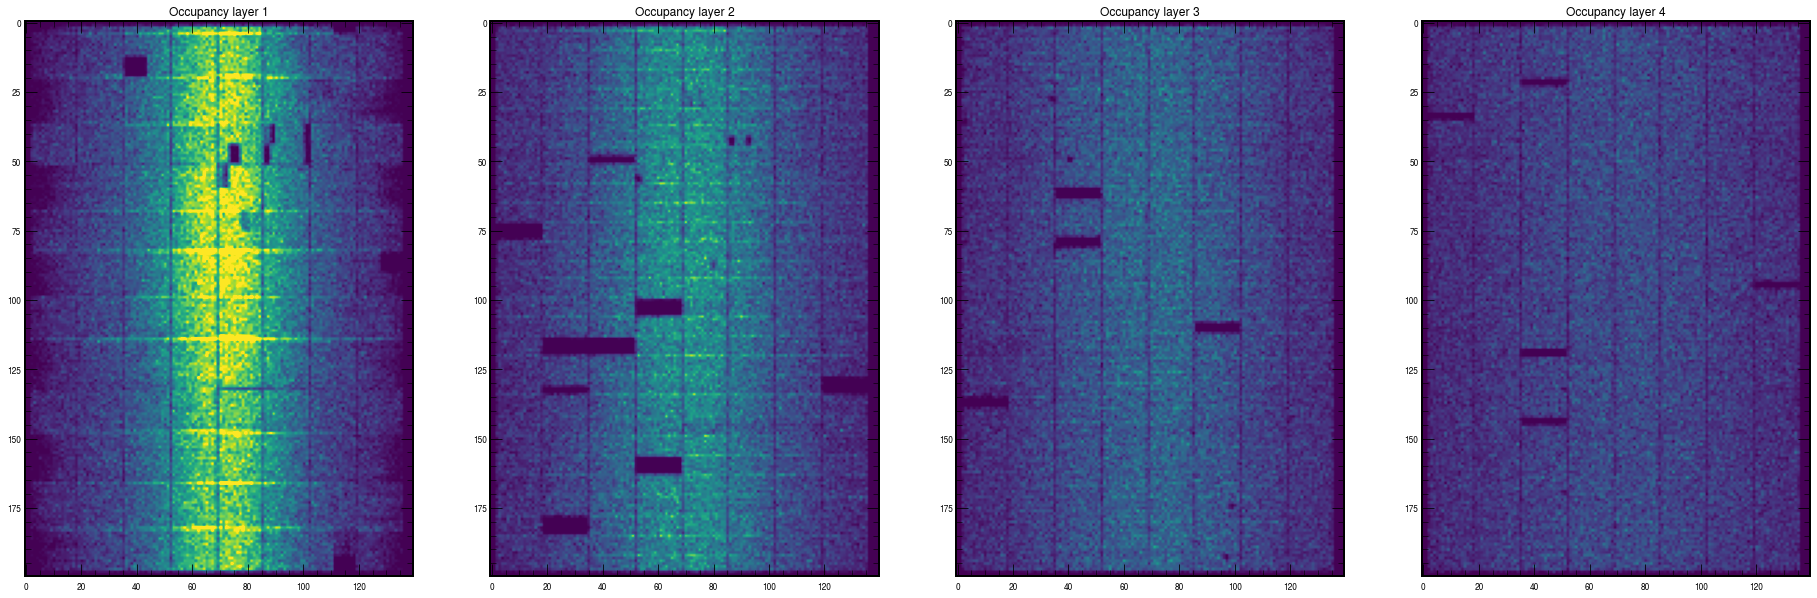

In [17]:
plt.figure(figsize=(32, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(sample_input[i].reshape((200, 140)), vmin=0, vmax=0.5)
    plt.title(f"Occupancy layer {i+1}")

# Inference

In [18]:
# Since we already have a model, inference should be pretty simple.
sample_output = [model.predict(h) for (h, model) in zip(sample_input, models)]

1/1 [==============================] - 0s 389ms/step


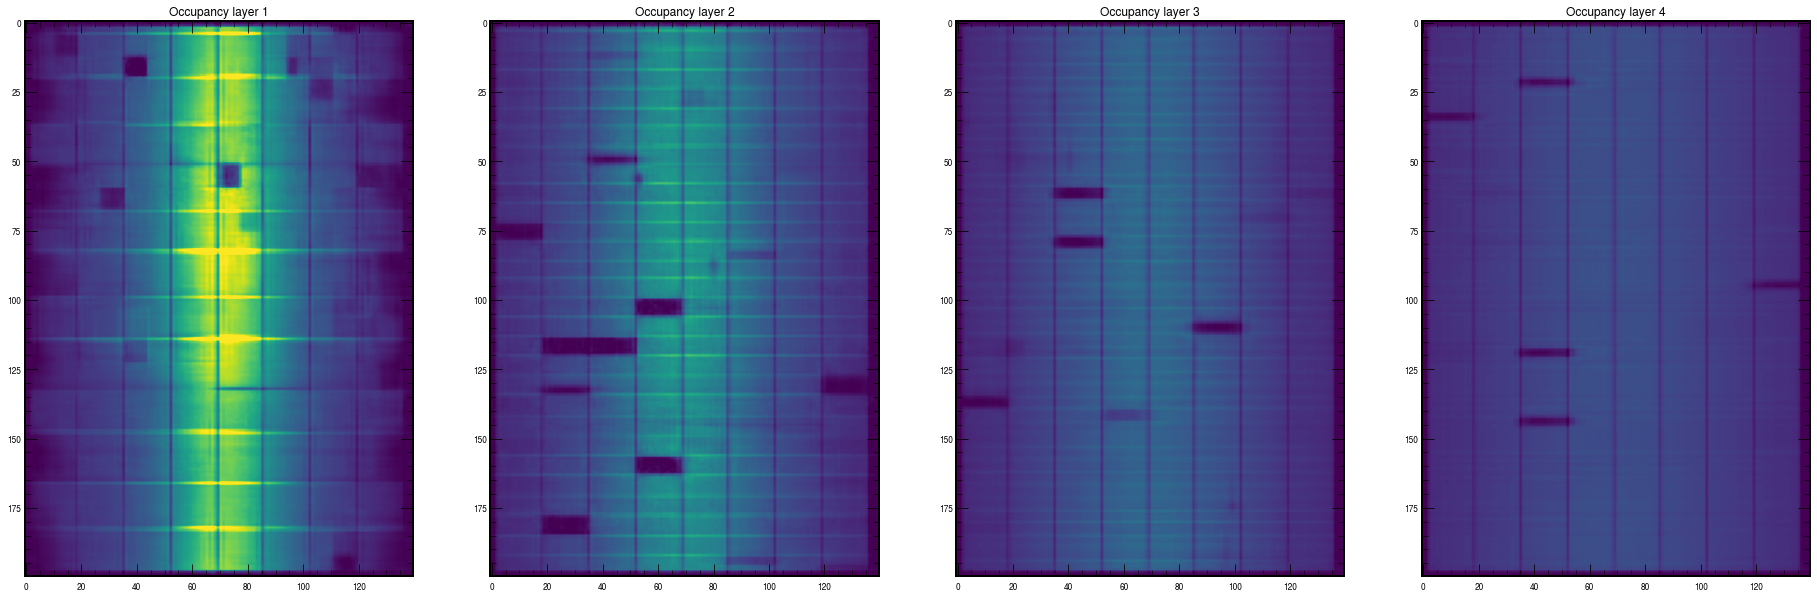

In [19]:
plt.figure(figsize=(32, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(sample_output[i].reshape((200, 140)), vmin=0, vmax=0.5)
    plt.title(f"Occupancy layer {i+1}")

In [20]:
differences = [np.array(keras.losses.mse(inputhist, outputhist)) for (inputhist, outputhist) in zip(sample_input, sample_output)]

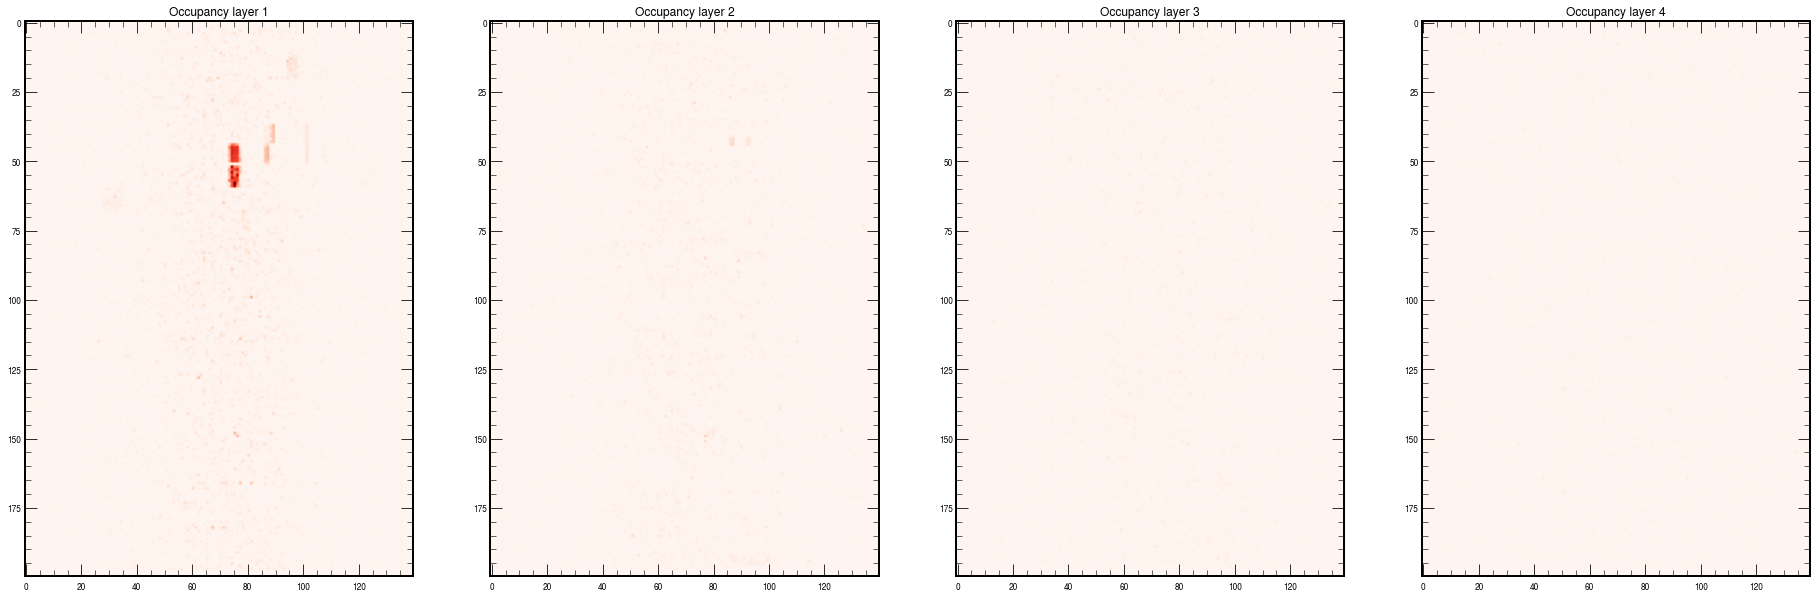

In [21]:
plt.figure(figsize=(32, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(differences[i].reshape((200, 140)), vmin=0, vmax=0.25, cmap="Reds")
    plt.title(f"Occupancy layer {i+1}")

In [22]:
# We can also calculate mean of 
[np.mean(d) for d in differences]

[0.0021830888, 0.0013725508, 0.0010225932, 0.00080899504]

With these reconstructions and differences, we can use them to summarise the reconstruction and see the error for any lumisection.

In [23]:
def plot_zphi_set(runnr, lumisection):
    FONTSIZE=15
    inputhists, rate = gethist(runnr, lumisection)
    mainfig = plt.figure(figsize=(20, 17), facecolor="white")
    #fig, axes = plt.subplots(nrows=3, ncols=4)
    #fig.tight_layout()
    plt.subplots_adjust(left=0.1, bottom=None, right=0.9, top=None, wspace=None, hspace=None)
    for i in range(4):
        outputhist = models[i].predict(inputhists[i])
        difference = keras.losses.mse(inputhists[i], outputhist)
        
        outputhist = np.reshape(outputhist, (200, 140))
        difference = np.reshape(difference, (200, 140))
        
        ax = plt.subplot(3, 4, i+1)
        if i == 0: leftbound, _, mainfig_width, _ = plt.gca().get_position().bounds
        plot_truth = ax.imshow(inputhists[i].reshape(200, 140), vmin=0, vmax=0.5)
        plt.title(f"Barrel layer {i+1} original", fontsize=FONTSIZE)
        cbar = plt.colorbar(plot_truth)
        cbar.ax.set_ylabel("Normalised occupancy", fontsize=FONTSIZE)
        cbar.ax.tick_params(labelsize=FONTSIZE) 
        plt.tick_params(labelsize=FONTSIZE)
        plt.xticks(ticks=[70 + 140/56*i for i in range(-20, 21, 10)], labels=range(-20, 21, 10))
        plt.yticks(ticks=[100+100/3.2*i for i in np.arange(-3, 4, 1)], labels=range(-3, 4))
        plt.xlabel("Global z (cm)", fontsize=FONTSIZE)
        plt.ylabel("Global $\phi$", fontsize=FONTSIZE)
        #hep.cms.label(fontsize=FONTSIZE, loc=4)
        plt.gca().invert_yaxis()
        
        ax_pred = plt.subplot(3, 4, i+5)
        plot_pred = ax_pred.imshow(outputhist, vmin=0, vmax=0.5)
        cbar_reconstructed = plt.colorbar(plot_pred)
        cbar_reconstructed.ax.set_ylabel("Normalised occupancy", fontsize=FONTSIZE)
        cbar_reconstructed.ax.tick_params(labelsize=FONTSIZE) 
        plt.tick_params(labelsize=FONTSIZE)
        plt.xticks(ticks=[70 + 140/56*i for i in range(-20, 21, 10)], labels=range(-20, 21, 10))
        plt.yticks(ticks=[100+100/3.2*i for i in np.arange(-3, 4, 1)], labels=range(-3, 4))
        plt.title(f"Reconstructed", fontsize=FONTSIZE)
        plt.xlabel("Global z (cm)", fontsize=FONTSIZE)
        plt.ylabel("Global $\phi$", fontsize=FONTSIZE)
        #hep.cms.label(fontsize=FONTSIZE, loc=4)
        plt.gca().invert_yaxis()
        
        ax_mse = plt.subplot(3, 4, i+9)
        if i == 3: rightmost_leftbound, _, mainfig_width, _ = plt.gca().get_position().bounds
        plot_mse = ax_mse.imshow(difference, vmin=0, vmax=0.25, cmap="Reds")
        cbar_mse = plt.colorbar(plot_mse)
        cbar_mse.ax.set_ylabel("Mean squared error", fontsize=FONTSIZE)
        cbar_mse.ax.tick_params(labelsize=FONTSIZE) 
        plt.tick_params(labelsize=FONTSIZE)
        plt.xticks(ticks=[70 + 140/56*i for i in range(-20, 21, 10)], labels=range(-20, 21, 10))
        plt.yticks(ticks=[100+100/3.2*i for i in np.arange(-3, 4, 1)], labels=range(-3, 4))
        plt.title(f"MSE", fontsize=FONTSIZE)
        plt.xlabel("Global z (cm)", fontsize=FONTSIZE)
        plt.ylabel("Global $\phi$", fontsize=FONTSIZE)
        #plt.title(f"MSE: {MSE_mean:.6f}/{MSE_max:.6f}/{MSE_std:.6f}")
        #plt.colorbar()
        #hep.cms.label(fontsize=FONTSIZE, loc=0)
        plt.gca().invert_yaxis()
        
    cms_text = mainfig.text(leftbound, 0.92, "CMS", fontsize=FONTSIZE*1.3, fontweight='bold', horizontalalignment="left")
    mainfig.canvas.draw()
    #print(mainfig.get_size_inches())
    exp_offset = cms_text.get_window_extent().width/mainfig.dpi/mainfig.get_size_inches()[0]*1.05
    #print(exp_offset)
    mainfig.text(leftbound + exp_offset, 0.92, f"Run {runnr}, Lumisection {lumisection}", fontsize=FONTSIZE, style="italic", horizontalalignment="left")
    mainfig.text(rightmost_leftbound + mainfig_width, 0.92, "2017 (13 TeV)", fontsize=FONTSIZE, horizontalalignment="right")
    #plt.suptitle(f"Run {runnr}, Lumisection {lumisection}")
    #resnet_predict_and_compare(6, 297100, 229)

1/1 [==============================] - 0s 47ms/step


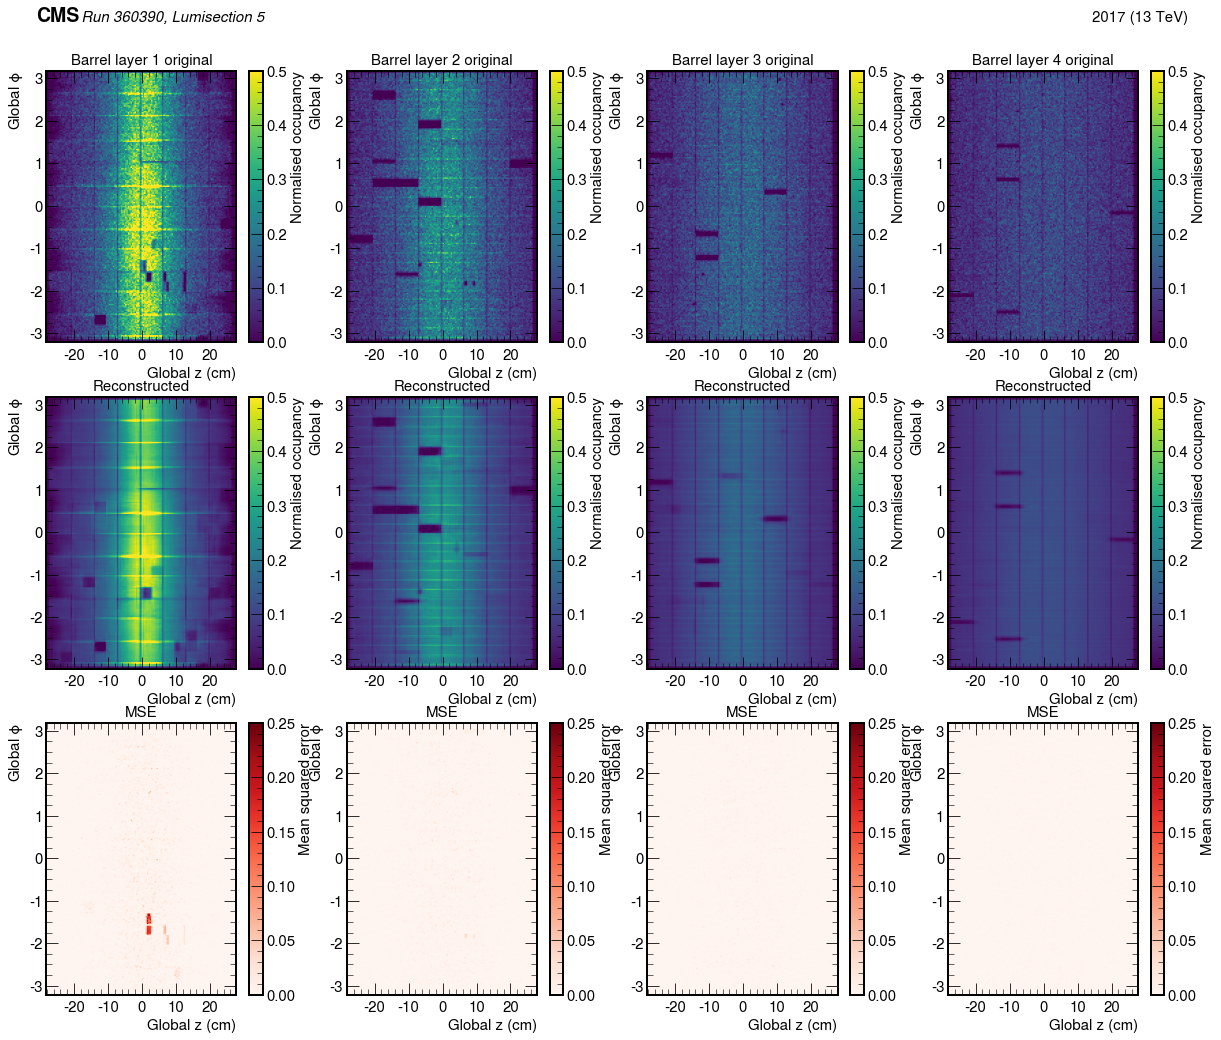

In [24]:
plot_zphi_set(360390, 5)

# Inference on several lumisections

The ultimate goal of autoencoders is to detect anomalies. This can be done by using the assumption that autoencoders will be able to reconstruct the histograms perfectly if the histogram itself does not have any issues, like a large portion of a subdetector does not work. On the other hand, it should reconstruct bad histograms poorly. This can be reflected with high reconstruction losses, which we already calculated as MSE.

We can also use the MSE information from each histogram from all lumisections and cluster them using unsupervised methods like PCA. In the example below, we will calculate MSE losses from four histograms in each lumisection, bundled them up as a four-dimensional tuple per lumisection, and throw them into PCA analysis.

In [25]:
#differences_list = []
#for _, row in datasetrate_df[:1000].iterrows(): # To save time, we will limit ourselves at the first 5000 lumisections.
#    inputhists, _ = gethist(row["run_number"], row["lumisection_number"])
#    reconstructed = [model.predict(h) for (h, model) in zip(inputhists, models)]
#    differences = [np.array(keras.losses.mse(inputhist, outputhist)) for (inputhist, outputhist) in zip(inputhists, reconstructed)]
#    differences_list.append([np.mean(d) for d in differences])

As you might see, inferring 1000 lumisections on SWAN can be slow, not to mention 44k lumisections we have in 2022F data. Therefore, we have compiled losses from all lumisections in 2022F for you here.

In [26]:
zphi_losses = pd.DataFrame(columns=["runnr", "lumisection"])
for i in range(1, 5):
    zphi_losses = pd.merge(zphi_losses, pd.read_csv(f"/eos/home-v/vwachira/public/DESY ML tutorial/losses_2022F/zphi{i}_losses_0.50_merged.csv")\
                           [["runnr", "lumisection", f"zphi{i}_MSE_mean"]],
                           on=["runnr", "lumisection"], how="outer")
zphi_losses = zphi_losses.dropna()

We can quickly perform PCA on this list of a tuple containing mean MSE.

In [27]:
from sklearn.decomposition import PCA
pca_MSEmean_obj = PCA(n_components=2)
pca_MSEmean_obj.fit(zphi_losses[[f"zphi{i}_MSE_mean" for i in range(1, 5)]])

PCA(n_components=2)

In [28]:
pca_MSEmean_obj.transform(zphi_losses[[f"zphi{i}_MSE_mean" for i in range(1, 5)]])

array([[-2.18519646e-03,  7.15815948e-06],
       [-2.18266833e-03,  4.68088755e-05],
       [-2.31341375e-03,  8.70560839e-05],
       ...,
       [-8.58091615e-04, -3.31549010e-05],
       [-8.09737815e-04, -2.71541791e-05],
       [-7.44228540e-04, -1.87833517e-05]])

In [29]:
zphi_losses[[f"zphi{i}_MSE_mean" for i in range(1, 5)]].to_numpy()

array([[0.00218309, 0.00137255, 0.00102259, 0.000809  ],
       [0.00213522, 0.00140966, 0.0010432 , 0.0008257 ],
       [0.00201521, 0.00136208, 0.00099001, 0.00081321],
       ...,
       [0.00284482, 0.00243428, 0.00153143, 0.00118429],
       [0.00287779, 0.00244771, 0.00156263, 0.00120199],
       [0.00293157, 0.00244688, 0.00161547, 0.00122285]])

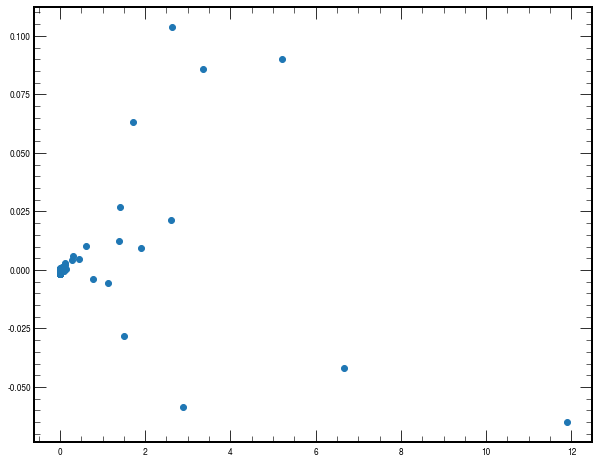

In [37]:
plt.figure(figsize=(10, 8))
plt.scatter(*(pca_MSEmean_obj.transform(zphi_losses[[f"zphi{i}_MSE_mean" for i in range(1, 5)]]).transpose()))

What's interesting is that with PCA we can see several outliers. We can do a little investigation and see what these lumisections are.

In [31]:
zphi_losses["PCA_a1"] = pca_MSEmean_obj.transform(zphi_losses[[f"zphi{i}_MSE_mean" for i in range(1, 5)]])[:, 0]
zphi_losses["PCA_a2"] = pca_MSEmean_obj.transform(zphi_losses[[f"zphi{i}_MSE_mean" for i in range(1, 5)]])[:, 1]

In [39]:
zphi_losses[zphi_losses["PCA_a1"] > 1]

runnr  lumisection  zphi1_MSE_mean  zphi2_MSE_mean  zphi3_MSE_mean  \
462    360430            1        7.819355        6.008951        5.416782   
491    360433            1        1.906804        1.511053        1.224944   
2606   360486          458        0.740156        0.582853        0.508427   
5785   360888          292        1.234466        0.965743        0.884200   
5786   360888          294        1.708645        1.295567        1.167373   
9719   360942          345        2.129775        1.699971        1.585440   
10107  360946          367        0.899800        0.710914        0.640172   
18740  361239         1086        1.071307        0.890972        0.798212   
23936  361361           70        4.335515        3.495322        2.965763   
23969  361361          104        3.366005        2.634033        2.349335   
23970  361361          105        1.010628        0.788003        0.637377   
24178  361364          158        0.912056        0.728346        0.637117   
42331  362153           82        1.666070        1.311414        1.221129   

       zphi4_MSE_mean     PCA_a1    PCA_a2  
462          3.877848  11.895250 -0.064981  
491          0.949755   2.878129 -0.058480  
2606         0.372634   1.128463 -0.005740  
5785         0.626257   1.900205  0.009237  
5786         0.900470   2.596739  0.021289  
9719         1.150649   3.349679  0.085685  
10107        0.468150   1.389169  0.012520  
18740        0.613804   1.712640  0.063415  
23936        2.198928   6.675643 -0.041685  
23969        1.831303   5.203581  0.090304  
23970        0.510733   1.513599 -0.028110  
24178        0.502322   1.416011  0.027066  
42331        0.956786   2.620071  0.103925

1/1 [==============================] - 0s 31ms/step


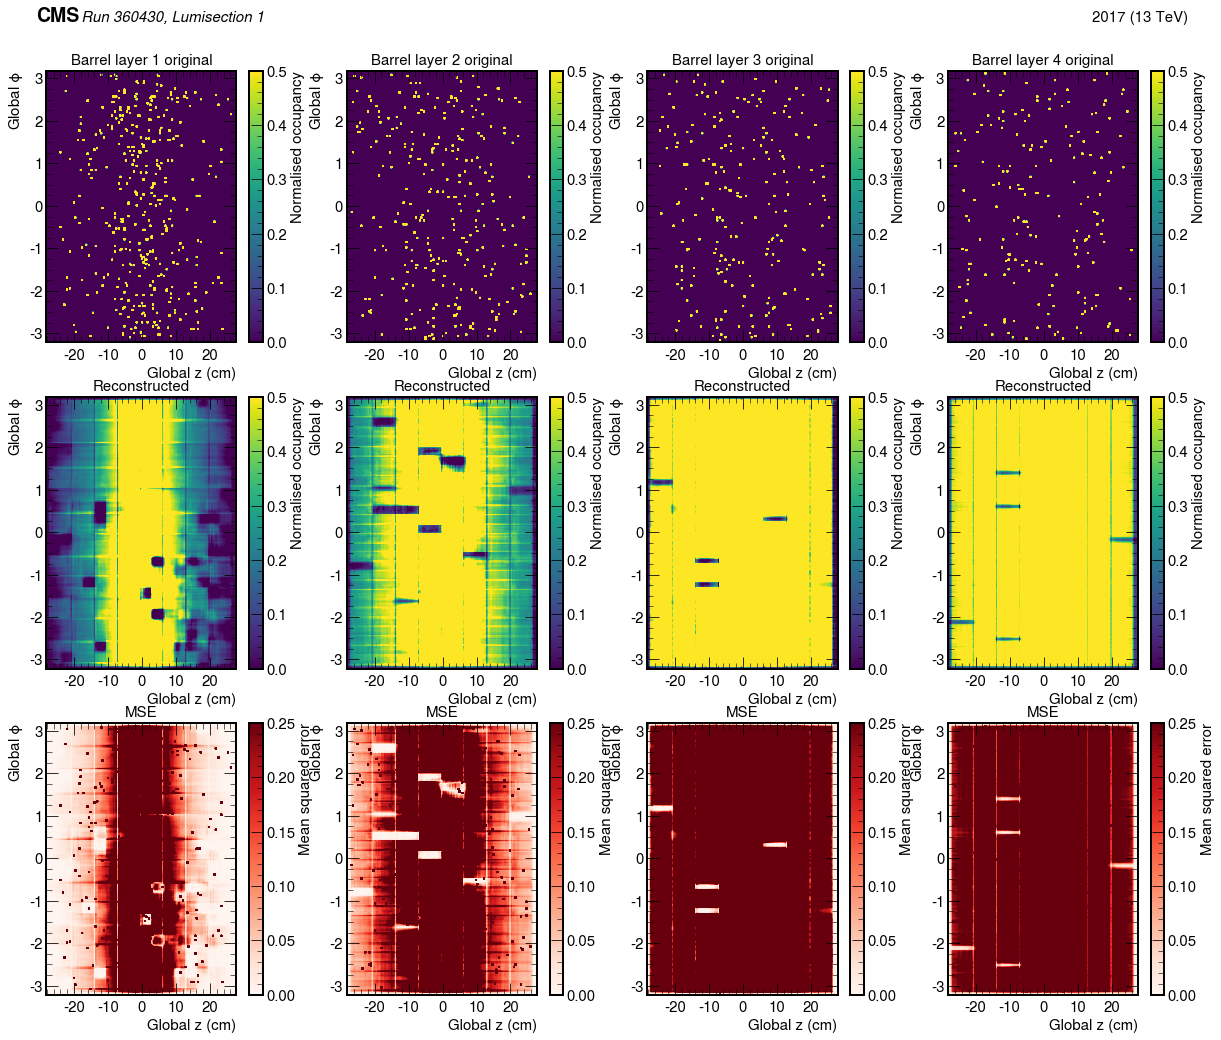

In [33]:
plot_zphi_set(360430, 1)

1/1 [==============================] - 0s 29ms/step


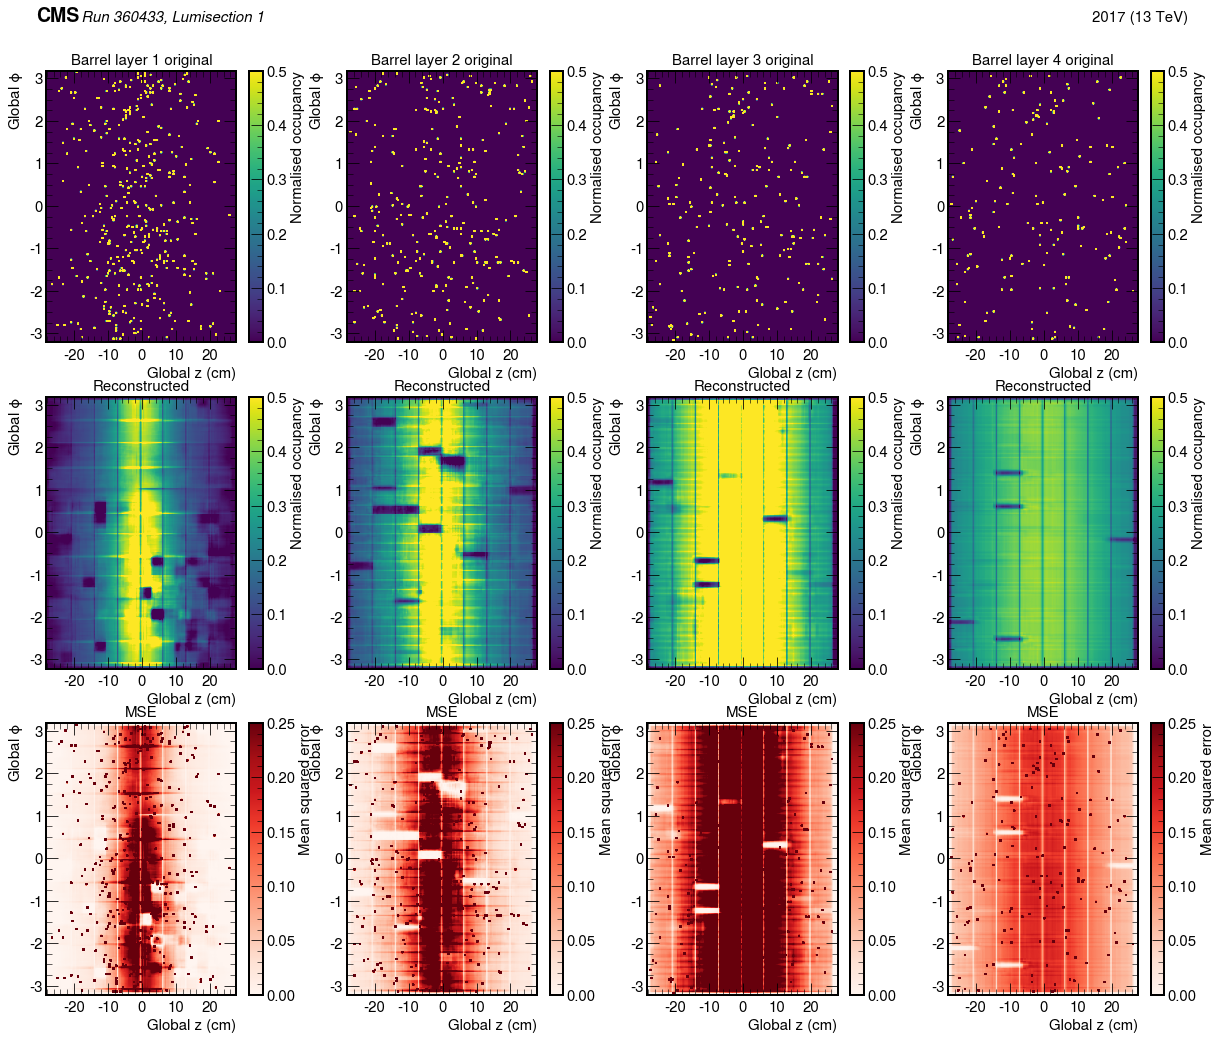

In [34]:
plot_zphi_set(360433, 1)

1/1 [==============================] - 0s 30ms/step


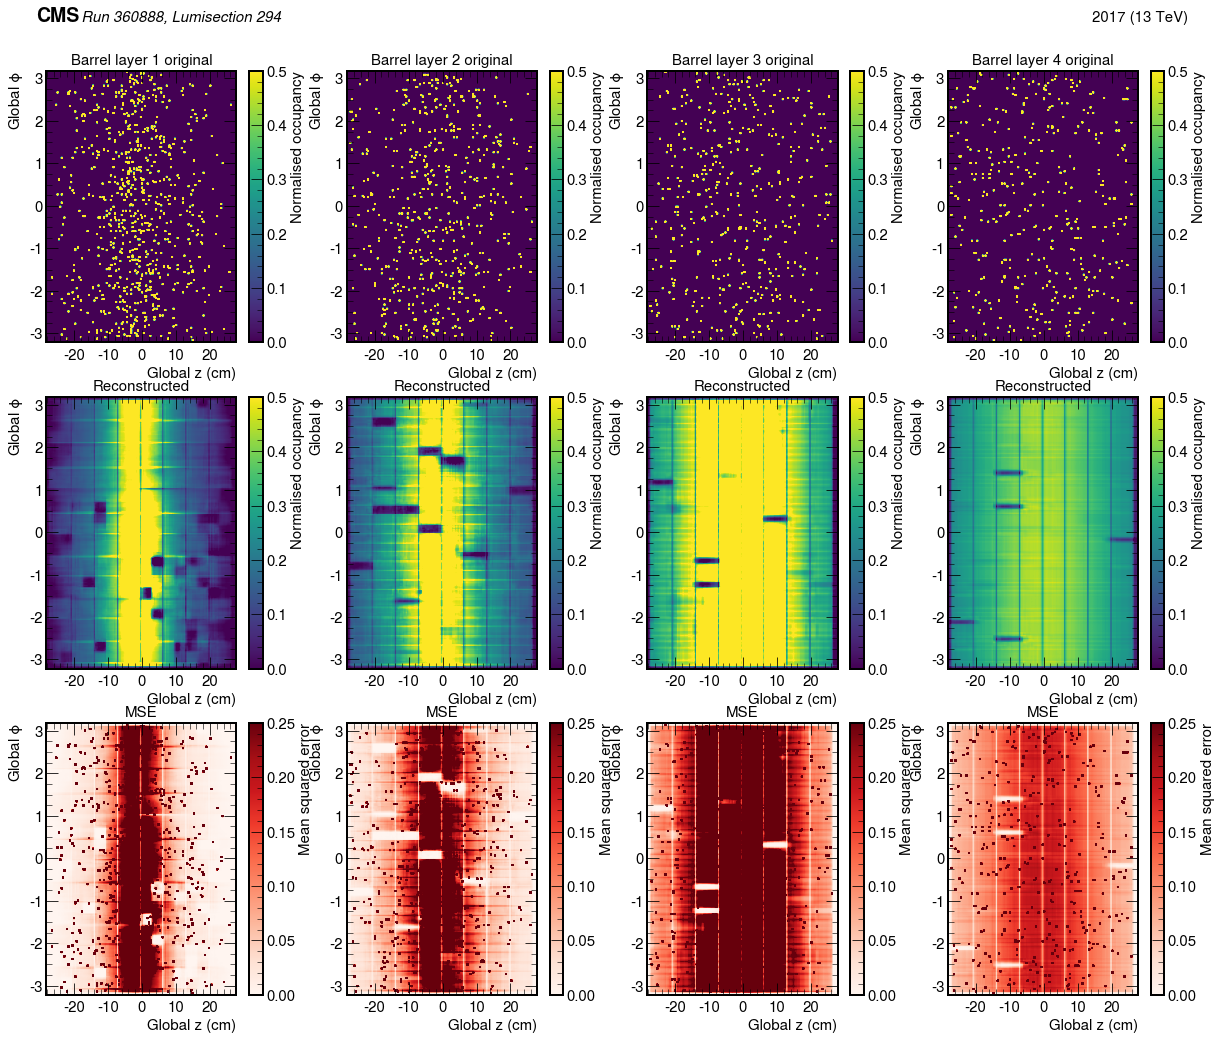

In [35]:
plot_zphi_set(360888, 294)

1/1 [==============================] - 0s 45ms/step


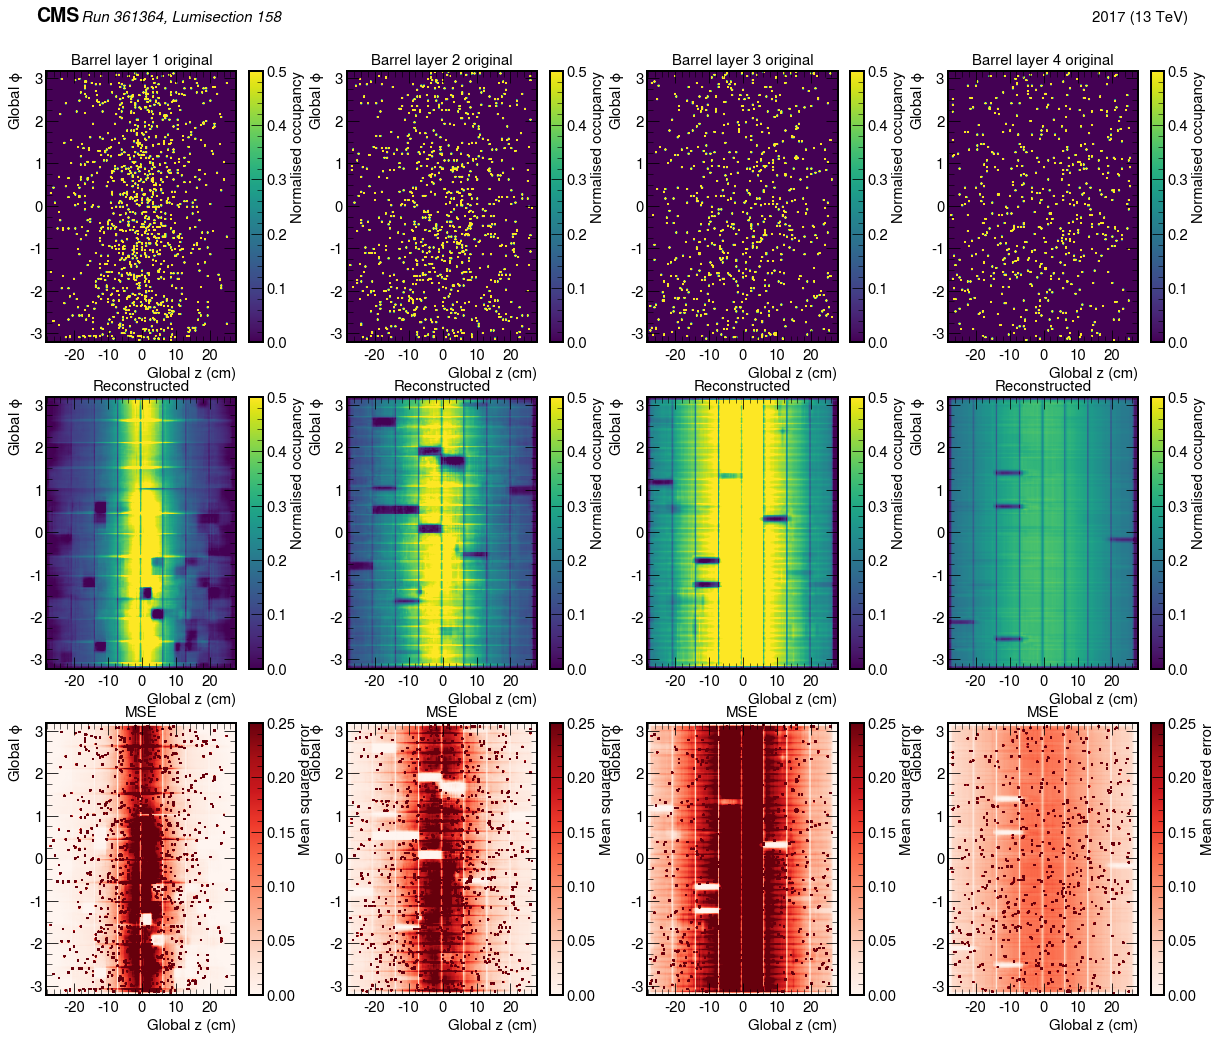

In [43]:
plot_zphi_set(361364, 158)

We can also zoom in to the region where a lot of lumisections cluster in the PCA plot and try to understand where and how they are clustered.

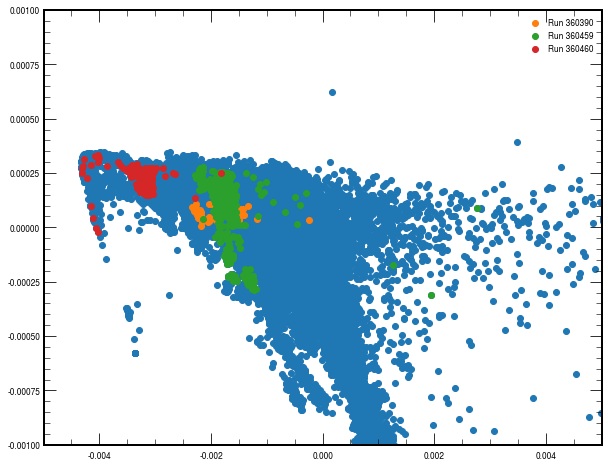

In [38]:
plt.figure(figsize=(10, 8))
plt.scatter(zphi_losses["PCA_a1"], zphi_losses["PCA_a2"])
plt.scatter(zphi_losses[zphi_losses["runnr"]==360390]["PCA_a1"], zphi_losses[zphi_losses["runnr"]==360390]["PCA_a2"], label="Run 360390")
plt.scatter(zphi_losses[zphi_losses["runnr"]==360459]["PCA_a1"], zphi_losses[zphi_losses["runnr"]==360459]["PCA_a2"], label="Run 360459")
plt.scatter(zphi_losses[zphi_losses["runnr"]==360460]["PCA_a1"], zphi_losses[zphi_losses["runnr"]==360460]["PCA_a2"], label="Run 360460")
plt.xlim(-0.005, 0.005)
plt.ylim(-0.001, 0.001)
plt.legend()

In [45]:
datasetrate_df

run_number  lumisection_number  rate_ZeroBias
0          360390                   5     105.489352
1          360390                   6     106.390237
2          360390                   7     106.004143
3          360390                   8     104.159474
4          360390                   9     107.848813
...           ...                 ...            ...
44344      362167                 642      78.033807
44345      362167                 643      81.422851
44346      362167                 644      79.663980
44347      362167                 645      78.462800
44348      362167                 646      79.663980

[44349 rows x 3 columns]

In [48]:
lumi_rate_pd = pd.merge(zphi_losses, datasetrate_df, left_on=["runnr", "lumisection"], right_on=["run_number", "lumisection_number"], how="inner")

(-0.001, 0.001)

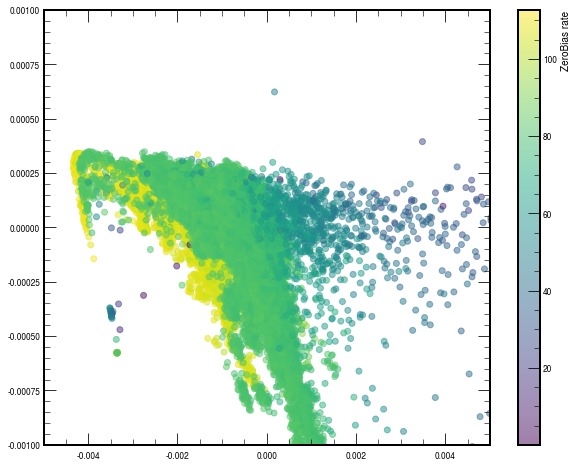

In [57]:
plt.figure(figsize=(10, 8))
plt.scatter(lumi_rate_pd["PCA_a1"], lumi_rate_pd["PCA_a2"], c=lumi_rate_pd["rate_ZeroBias"], alpha=0.5)
plt.colorbar(label="ZeroBias rate")
plt.xlim(-0.005, 0.005)
plt.ylim(-0.001, 0.001)

As you can see, tools like 2D autoencoders and PCA can help us look into a large set of data from an entire era of 2022F. However, creativity doesn't end here, as you can still apply any kind of tool for anomaly detection!